In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
!pip install tensorflow tensorflow_decision_forests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',90)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import KFold,cross_validate
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import tensorflow_decision_forests as tfdf
from tensorflow_decision_forests.keras import RandomForestModel,pd_dataframe_to_tf_dataset

2024-03-03 06:04:52.536489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 06:04:52.536679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 06:04:52.692761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
train0 = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test0 = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [6]:
train0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [9]:
test0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType        894
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

### To Fill the missing Values in a better way , we may use the information test set as well to fill them

> Combining The Train & Test Set

In [10]:
train0.shape

(1460, 81)

In [11]:
test0.shape

(1459, 80)

In [12]:
data0 = pd.concat([train0,test0]).reset_index()

In [13]:
data0.tail()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,NaN,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


In [14]:
data0.drop(['index','Id'],axis=1,inplace=True)

In [15]:
data0.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [16]:
target = train0['SalePrice']

In [17]:
data0.drop('SalePrice',axis=1,inplace=True)

# Dealing Categorical NA Values

In [18]:
data1 = data0.copy()

In [19]:
#Na attributes having some specific meaning such as None
for col in ['Alley',
            'BsmtQual',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinType2',
            'FireplaceQu',
            'GarageType',
            'GarageFinish',
            'GarageQual',
            'GarageCond',
            'PoolQC',
            'Fence',
            'MiscFeature']:
    data1[col].fillna('None',inplace=True)

In [20]:
data1['GarageCars'] = data1['GarageCars'].astype(str)
data1['BsmtFullBath'] = data1['BsmtFullBath'].astype(str)
data1['BsmtHalfBath'] = data1['BsmtHalfBath'].astype(str)

In [21]:
cat_cols = [col for col in data1.select_dtypes(exclude=np.number) if data1[col].nunique()<20 and data1[col].isna().sum()>0 ]

In [22]:
cat_cols

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtCond',
 'Electrical',
 'KitchenQual',
 'Functional',
 'SaleType']

In [23]:
for col in ['MSZoning',
            'Utilities',
            'Exterior1st',
            'Exterior2nd',
            'MasVnrType',
            'BsmtCond',
            'Electrical',
            'KitchenQual',
            'Functional',
            'SaleType']:
    data1[col].fillna(data1[col].mode().iloc[0], inplace=True)

In [24]:
data1.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea        23
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         1
BsmtFinType2       0
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

# Dealing with Numeric NA Values

In [25]:
num_na_cols = data1.select_dtypes(include=np.number).columns[data1.select_dtypes(include=np.number).isna().sum() > 0]

In [26]:
data1[num_na_cols].head()


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
0,65.0,196.0,706.0,0.0,150.0,856.0,2003.0,548.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,1976.0,460.0
2,68.0,162.0,486.0,0.0,434.0,920.0,2001.0,608.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1998.0,642.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,2000.0,836.0


> KNN Imputation

In [27]:
def impute(df,target):
    df = df.copy()
    non_na_cols = [col for col in df if df[col].isna().sum()==0 and col in df.select_dtypes(include=np.number) ]
    X_train = df[non_na_cols].loc[df[target].isna()==0]
    y_train = df[target].loc[df[target].isna()==0]
    X_test = df[non_na_cols].loc[df[target].isna()==1 ]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train,y_train)
    
    y_pred = knn.predict(X_test)
    
    df[target].loc[df[target].isna()==1] = y_pred

    return df

In [28]:
for col in num_na_cols:
    data1 = impute(data1,col)

In [29]:
data1.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

**Fully Cleaned**

# Time to Deal with The Distribution

In [30]:
data2 = data1.copy()

In [31]:
skewed_cols = data2.select_dtypes(include=np.number).columns[abs(data2.select_dtypes(include=np.number).skew())>=0.5]

In [32]:
data2[skewed_cols].skew()

MSSubClass        1.376165
LotFrontage       1.341013
LotArea          12.829025
OverallCond       0.570605
YearBuilt        -0.600114
MasVnrArea        2.604799
BsmtFinSF1        1.426116
BsmtFinSF2        4.148275
BsmtUnfSF         0.919275
TotalBsmtSF       1.163350
1stFlrSF          1.470360
2ndFlrSF          0.862118
LowQualFinSF     12.094977
GrLivArea         1.270010
HalfBath          0.694924
KitchenAbvGr      4.304467
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
WoodDeckSF        1.843380
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

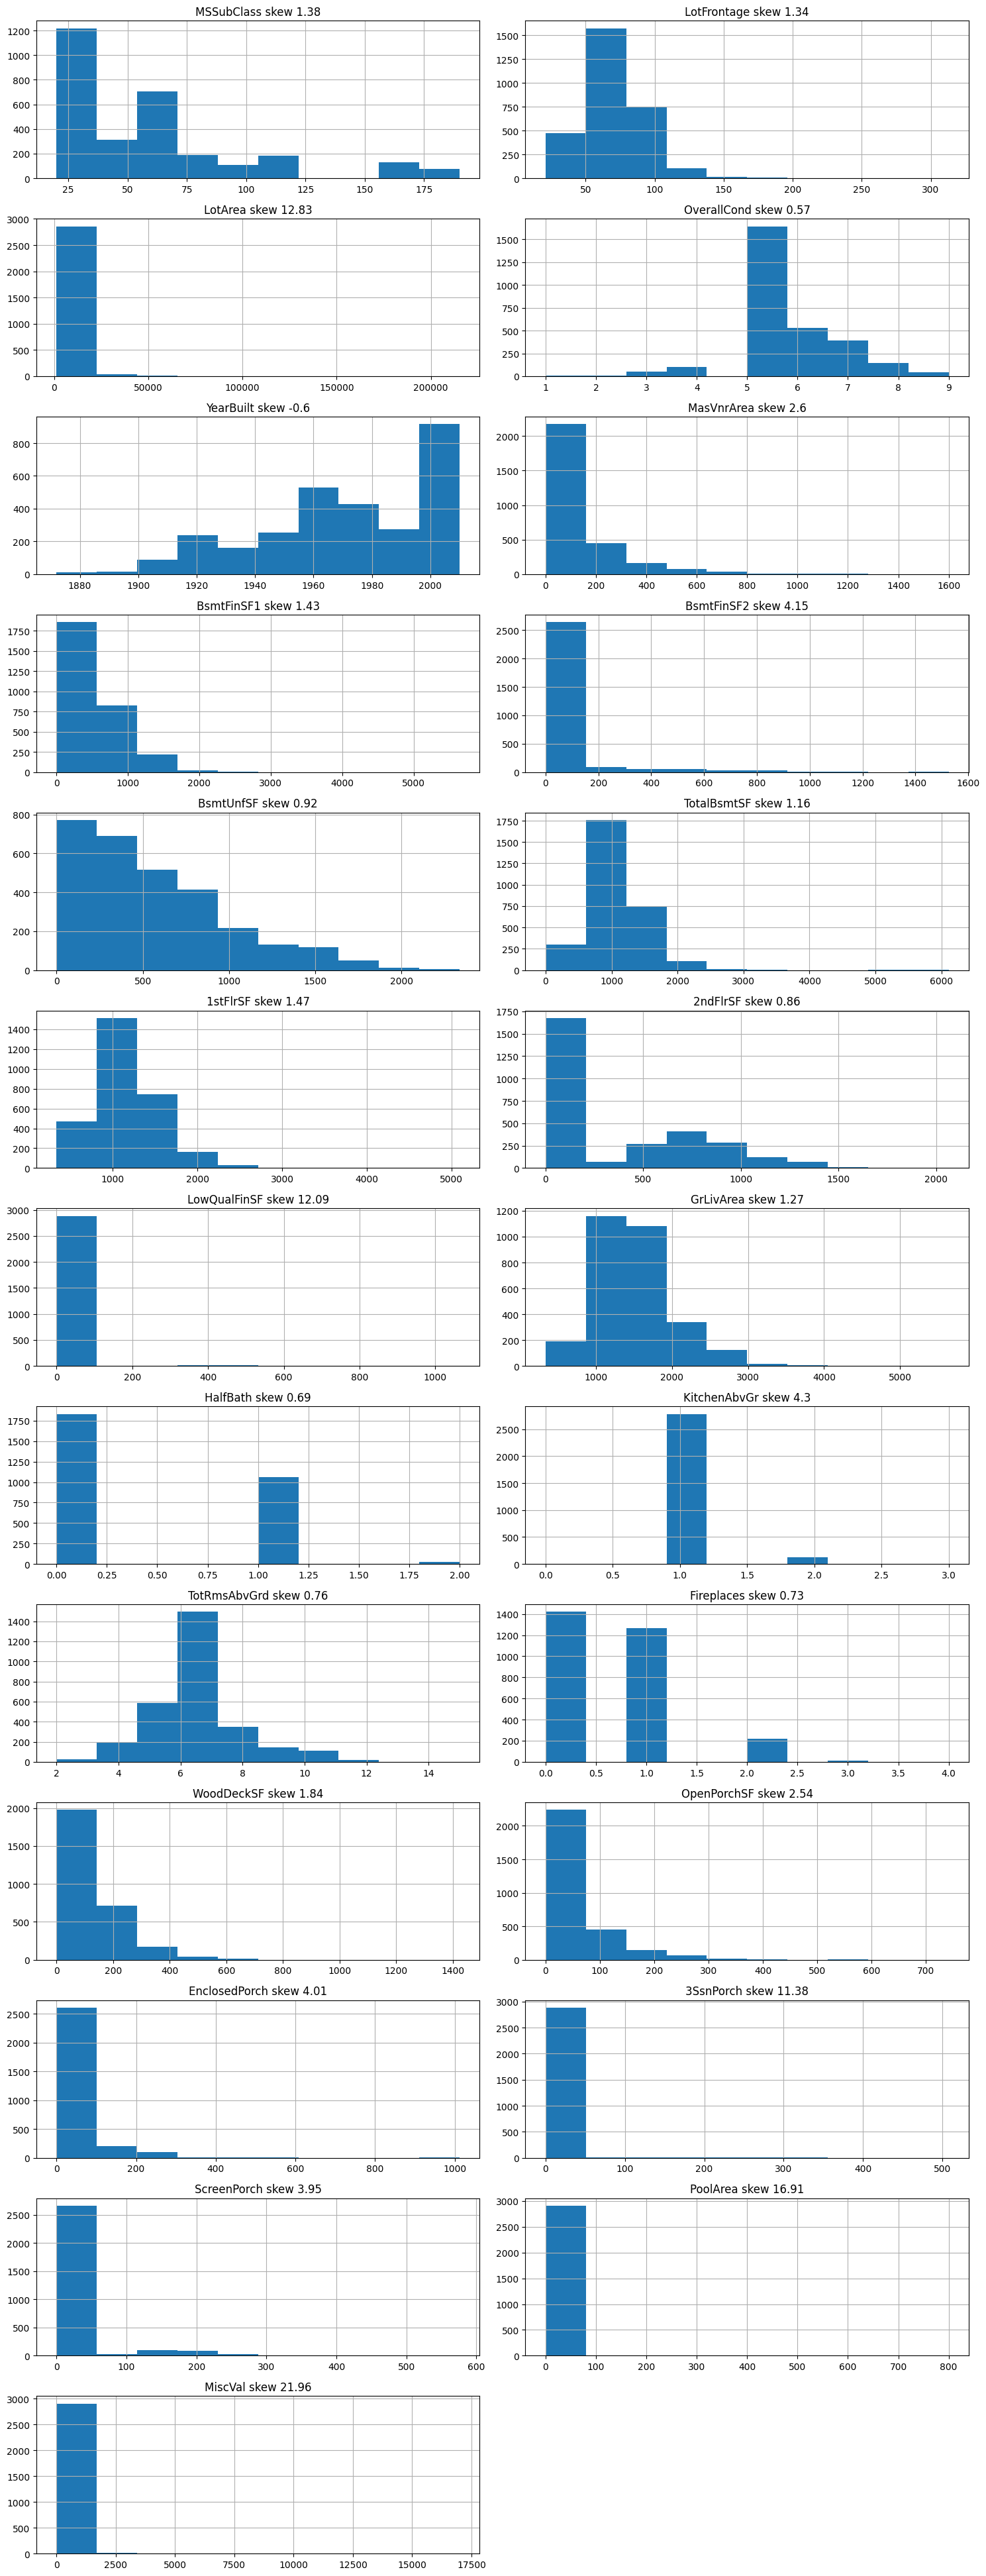

In [33]:
num_cols = len(skewed_cols)
num_rows = (num_cols // 2) + (num_cols % 2)  
plt.figure(figsize=(15, 3 * num_rows))

for i, col in enumerate(skewed_cols, 1):
    plt.subplot(num_rows, 2, i)
    data2[col].hist()
    plt.title(col+' skew '+str(np.round(data2[col].skew(),2)))

plt.tight_layout()
plt.show()

In [34]:
data2[skewed_cols] = np.log1p(data2[skewed_cols]) #log tranformation

> Let's Check the skewness

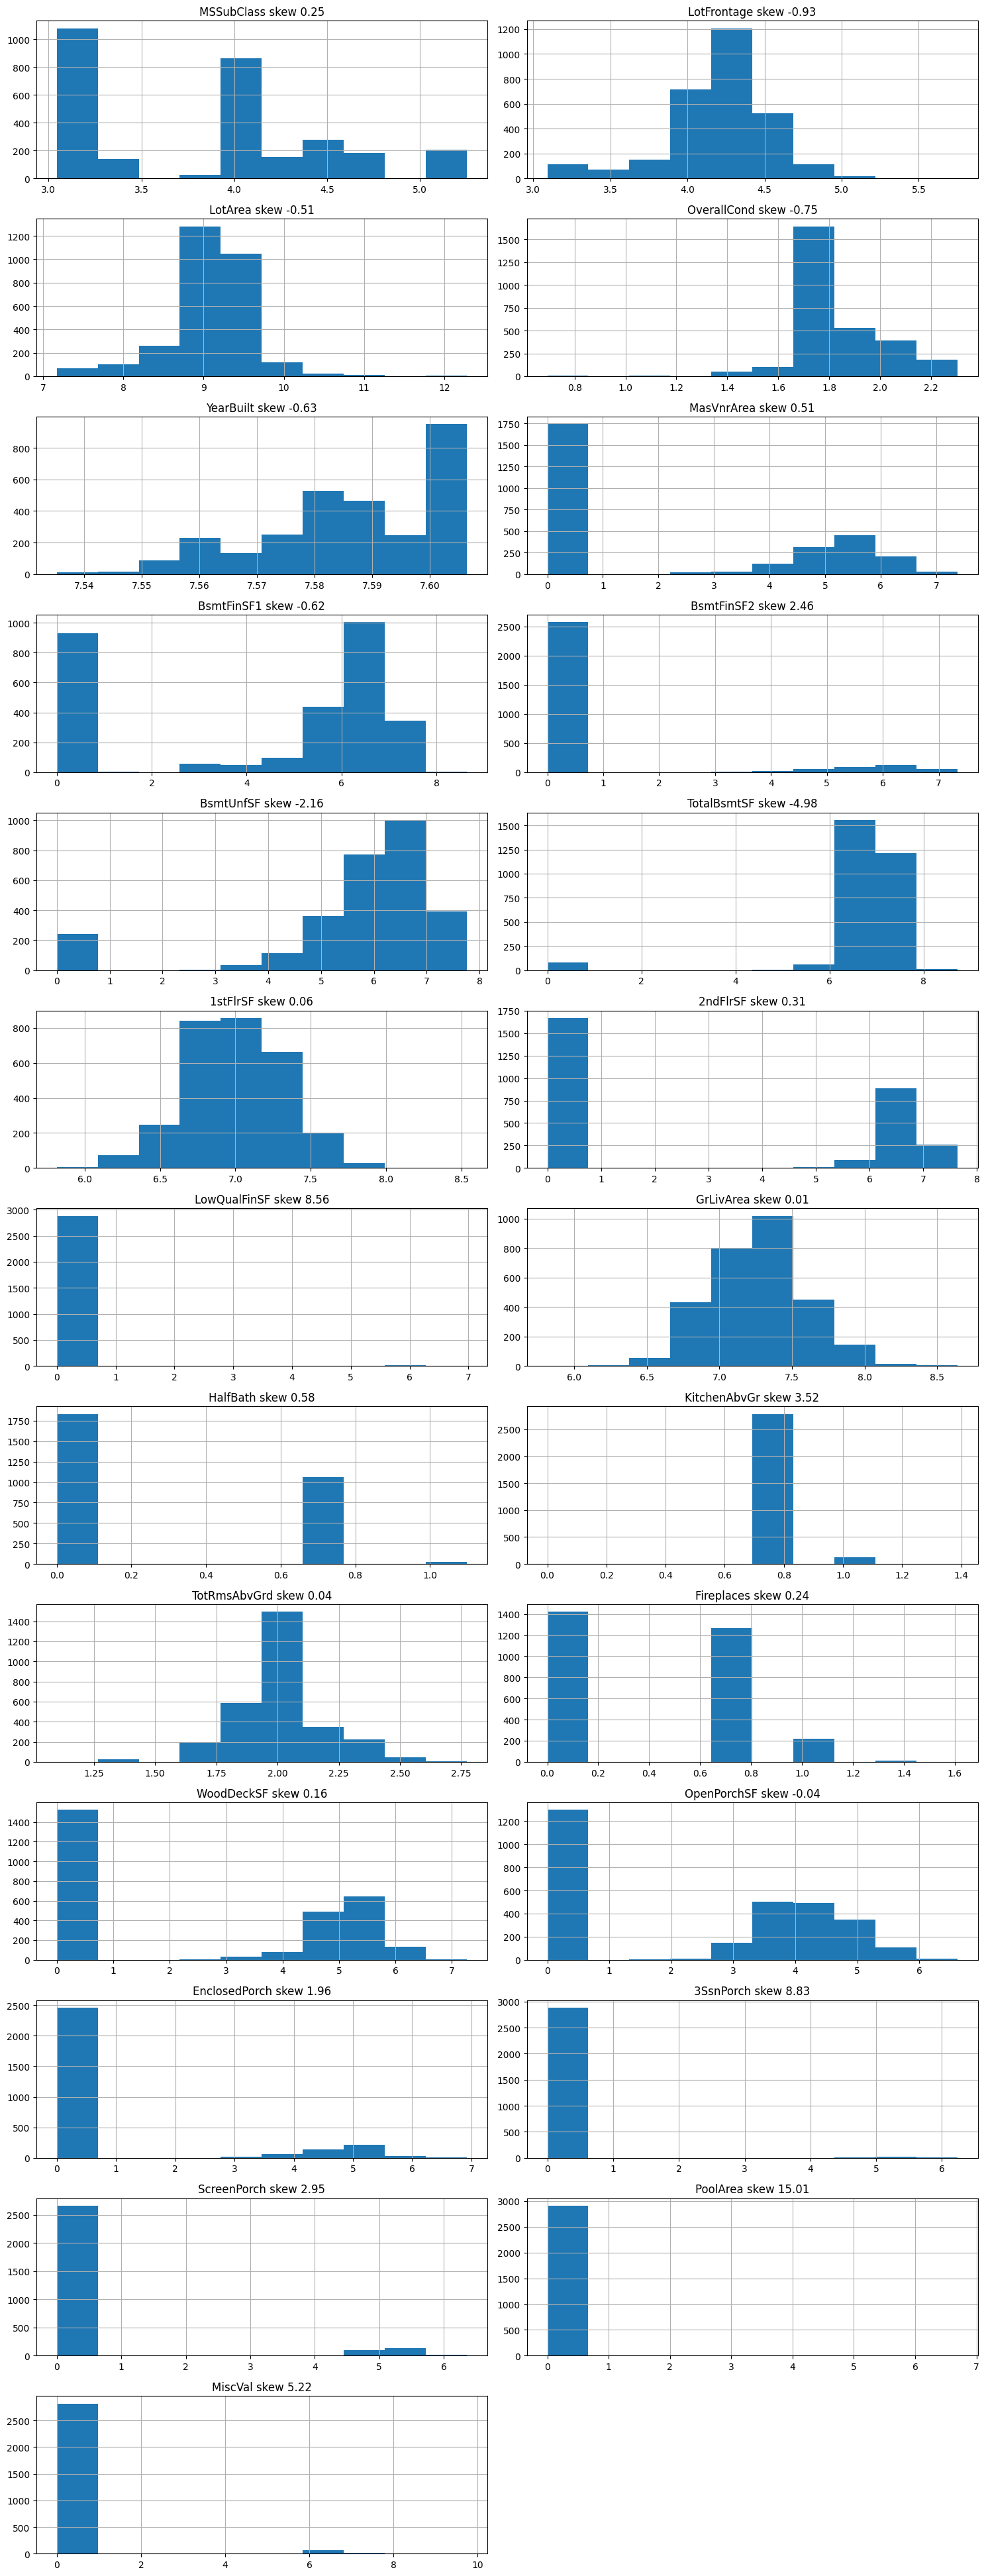

In [35]:
num_cols = len(skewed_cols)
num_rows = (num_cols // 2) + (num_cols % 2)  
plt.figure(figsize=(15, 3 * num_rows))

for i, col in enumerate(skewed_cols, 1):
    plt.subplot(num_rows, 2, i)
    data2[col].hist()
    plt.title(col+' skew '+str(np.round(data2[col].skew(),2)))

plt.tight_layout()
plt.show()

### Almost most of the features got better results in log transformation

In [36]:
data2.select_dtypes(np.number).skew()

MSSubClass        0.245284
LotFrontage      -0.931338
LotArea          -0.505010
OverallQual       0.197212
OverallCond      -0.746567
YearBuilt        -0.626537
YearRemodAdd     -0.451252
MasVnrArea        0.511298
BsmtFinSF1       -0.618037
BsmtFinSF2        2.463749
BsmtUnfSF        -2.160261
TotalBsmtSF      -4.984250
1stFlrSF          0.064861
2ndFlrSF          0.305206
LowQualFinSF      8.562091
GrLivArea         0.013194
FullBath          0.167692
HalfBath          0.580990
BedroomAbvGr      0.326492
KitchenAbvGr      3.522161
TotRmsAbvGrd      0.035125
Fireplaces        0.237710
GarageYrBlt      -0.346430
GarageArea        0.241020
WoodDeckSF        0.158114
OpenPorchSF      -0.041819
EnclosedPorch     1.962089
3SsnPorch         8.829794
ScreenPorch       2.947420
PoolArea         15.006047
MiscVal           5.216665
MoSold            0.195985
YrSold            0.132467
dtype: float64

**MoSold**

> though they are normally distruibuted, they have to be transformed in a way such that it would be easier for the model to intrepet the relation of data points in cyclic data

## Cosine Transformation

In [37]:
#c=0.524 calcuated from https://www.desmos.com/calculator -> -cos(cx) since 1 & 12 month has close relative 
#to check
-np.cos(0.524*12),-np.cos(0.524*1) # since weather are more similar for(1,12)

(-0.999988409388913, -0.8658247218821448)

In [38]:
data2['MoSold'] = -np.cos(data2['MoSold']*0.524)

In [39]:
data2['MoSold'].skew()

-0.754735703711711

## Labelling The Categorical data using dummy method

In [40]:
data3 = data2.copy()

In [41]:
data4 = pd.get_dummies(data3,dtype=float)

## Splitting the train & test

In [42]:
train0.shape

(1460, 81)

In [43]:
train = data4.iloc[:1460,:-1]
test = data4.iloc[1460:,:]

In [44]:
train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=312)

# CatBoost Regressor

In [45]:
X_train = train
y_train = train0['SalePrice']

In [46]:
y_train = np.log(y_train)

In [47]:
cb = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=10,verbose=0)
cb.fit(X_train,y_train)

In [48]:
y_pred_cb = np.exp(cb.predict(test))

In [49]:
#Cross_val_score

In [50]:
kfold = KFold(n_splits=10)

In [51]:
cv = cross_validate(cb,X_train,y_train,cv=kfold,scoring=('r2',"neg_root_mean_squared_error") ,verbose=0)

In [52]:
np.exp(-np.mean(cv['test_neg_root_mean_squared_error']))

1.1377837225378433

### RMSE -> 1.13778 which is too good in terms of Price prediction

In [53]:
np.mean(cv['test_r2'])

0.89389878336025

**R Squared value also has very good metric , implies the quality of model**

In [54]:
test.shape

(1459, 313)

In [55]:
submission['SalePrice'] = y_pred_cb

In [56]:
submission.head(1)

,Id,SalePrice
0,1461,121973.262567


In [57]:
submission.to_csv('submission.csv',index=False)

> ### Submission ->1309 ->Score 0.13631

# TFDF Random Forest

In [58]:
final_train = pd.concat([X_train,y_train],axis=1)
rf = RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.fit(pd_dataframe_to_tf_dataset(final_train,label='SalePrice',task = tfdf.keras.Task.REGRESSION),task = tfdf.keras.Task.REGRESSION)

Use /tmp/tmpwn2csz_x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:12.529050. Found 1460 examples.
Training model...


[INFO 24-03-03 06:09:04.8931 UTC kernel.cc:1233] Loading model from path /tmp/tmpwn2csz_x/model/ with prefix 01c1c6ed13b74f29


Model trained in 0:00:09.168153
Compiling model...


[INFO 24-03-03 06:09:05.4464 UTC decision_forest.cc:660] Model loaded with 300 root(s), 138200 node(s), and 243 input feature(s).
[INFO 24-03-03 06:09:05.4466 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-03-03 06:09:05.4468 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [59]:
test_rf = pd_dataframe_to_tf_dataset(test,task = tfdf.keras.Task.REGRESSION)

In [60]:
y_predtf = rf.predict(pd_dataframe_to_tf_dataset(test,task = tfdf.keras.Task.REGRESSION))

2/2 [==============================] - 3s 111ms/step


In [61]:
submission['SalePrice'] = y_predtf

In [62]:
submission.to_csv('submissiontf.csv',index=False)

> ### Score: 0.14643

In [63]:
### Thank You , Hope it may benefits any ml enthuasists////,,,